In [19]:
import gym
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F


In [20]:
class neural_network(nn.Module):
    def __init__(self, state_space,
                 action_space):
        super(neural_network, self).__init__()

        
        self.Linear1 = nn.Linear(state_space, 64)
        self.Linear2 = nn.Linear(64, 64)
        self.Linear3 = nn.Linear(64, action_space)
        self.softmax = nn.Softmax(dim=0)

    def forward(self, x):
        
        x = F.relu(self.Linear1(x))
        x = F.relu(self.Linear2(x))
        x=self.Linear3(x)
        x = self.softmax(x)
        return x

In [21]:
def selct_action(state,Q_net):
    action_prob=Q_net(state)
    action = np.random.choice(np.array([0,1]), p=action_prob.data.numpy())
    
    return action

In [22]:
def generate_trajectory(env,neural_net, n_steps=1000):
        """
        Play a session and genrate a trajectory
        returns: arrays of states, actions, rewards
        """
        states, actions, rewards = [], [], []
        # initialize the environment
        s1 = env.reset()[0]
        s=torch.FloatTensor(s1)
        #generate n_steps of trajectory:
        for t in range(n_steps):
            act=selct_action(s,neural_net)
            next_state1, r, done, info,_= env.step(act)
            next_state=torch.FloatTensor(next_state1)
            #update arrays
            states.append(s1)
            actions.append(act)
            rewards.append(r)

            s = next_state
            s1= next_state1
            if done:
                break
        return states, actions, rewards

In [23]:
def get_rewards_to_go(rewards, gamma=0.99):
        T = len(rewards) # total number of individual rewards
        # empty array to return the rewards to go
        rewards_to_go = [0]*T
        rewards_to_go[T-1] = rewards[T-1]
        for i in range(T-2, -1, -1): #go from T-2 to 0
            rewards_to_go[i] = gamma * rewards_to_go[i+1] + rewards[i]
        return rewards_to_go

In [24]:
def log_ten(states,num_action):
    states = torch.FloatTensor(states)
    T=torch.zeros(states.shape[0],num_action)
    for i,s in enumerate(states):
        T[i]=Q(s)
    return T

In [25]:

def train_one_episode(states,num_action,actions, rewards, gamma=0.99, entropy_coef=1e-2):
    rewards_to_go = get_rewards_to_go(rewards, gamma)
    actions=torch.LongTensor(actions)
    rewards_to_go = torch.FloatTensor(rewards_to_go)
    # get log action probabilities from states
    Soft_max_actions=log_ten(states,num_action)
    log_probs = torch.log(Soft_max_actions)
    log_probs_for_actions = log_probs[range(len(actions)), actions]
    
    J = torch.mean(log_probs_for_actions*rewards_to_go)
    H = -(Soft_max_actions*log_probs).sum(-1).mean()
    
    loss = -(J+entropy_coef*H)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return np.sum(rewards)

In [26]:
env=gym.make("CartPole-v1")
num_states=env.observation_space.shape[0]
num_actions=env.action_space.n
Q = neural_network(state_space=num_states, 
             action_space=num_actions)
optimizer = torch.optim.Adam(Q.parameters(), lr=1e-3)

total_rewards = []
mean_reward_l=[]
for i in range(10000):
    states, actions, rewards = generate_trajectory(env,Q)
    reward = train_one_episode(states,num_actions,actions, rewards)
    total_rewards.append(reward)
    if i != 0 and i % 100 == 0:
        mean_reward = np.mean(total_rewards[-100:-1])
        mean_reward_l.append(mean_reward )
        print("mean_reward: {}, iteration: {}".format(mean_reward, i))
        
env.close()

mean_reward: 19.727272727272727, iteration: 100
mean_reward: 28.707070707070706, iteration: 200
mean_reward: 43.81818181818182, iteration: 300
mean_reward: 84.06060606060606, iteration: 400
mean_reward: 144.27272727272728, iteration: 500
mean_reward: 362.90909090909093, iteration: 600
mean_reward: 137.08080808080808, iteration: 700
mean_reward: 254.92929292929293, iteration: 800
mean_reward: 137.07070707070707, iteration: 900
mean_reward: 527.030303030303, iteration: 1000
mean_reward: 140.02020202020202, iteration: 1100
mean_reward: 535.8888888888889, iteration: 1200
mean_reward: 563.5959595959596, iteration: 1300
mean_reward: 83.31313131313131, iteration: 1400
mean_reward: 60.19191919191919, iteration: 1500
mean_reward: 86.81818181818181, iteration: 1600
mean_reward: 61.7979797979798, iteration: 1700
mean_reward: 265.16161616161617, iteration: 1800
mean_reward: 687.929292929293, iteration: 1900
mean_reward: 653.7272727272727, iteration: 2000
mean_reward: 103.60606060606061, iteration:

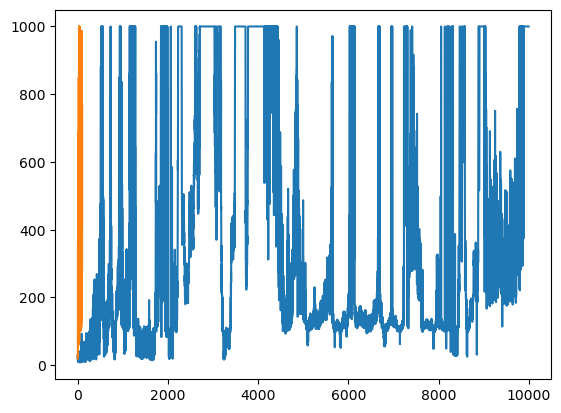

In [29]:
import matplotlib.pyplot as plt
plt.plot(total_rewards)
plt.plot(mean_reward_l)

In [32]:
done=False
env=gym.make("CartPole-v1", render_mode="human")
t=0
while not done:
    obs=env.reset()[0]
    
    obs=torch.tensor(obs)
    opt_policy = selct_action(obs,Q)
    next_state, reward, done, _,_ = env.step(opt_policy)
    env.render()
    obs=next_state
    t=t+1
    if t>=250:
        break
env.close()  